# Project second part 

### This jupyter will be organized in 3 parts :
- Data cleansing according to the mail instructions
- Data cleansing/modifications according to the article [here](5132133.pdf)
- Visualization which of five plots : 
    - plot of scaled vs non scaled features
    - bar plot of the most importants features
    - box plot of most efficient player from 3, 2 and paint
    - scatter plot of the impact of time on shot selection (dist)
    - scatter plot of the impact of time on shot accuracy
    - historigram of global shot accuracy at home and away

## Data cleansing and missing values

### Imports and load dataset

In [105]:
# Load data from shots_logs.csv file 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Troubleshooting with library versions
"""
print(f"Pandas version: {pd.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
"""
DATA_PATH = "shot_logs.csv"
nba_shots = pd.read_csv(DATA_PATH, encoding='utf-8')
print(nba_shots.head(5))

    GAME_ID                   MATCHUP LOCATION  W  FINAL_MARGIN  SHOT_NUMBER  \
0  21400899  MAR 04, 2015 - CHA @ BKN        A  W            24            1   
1  21400899  MAR 04, 2015 - CHA @ BKN        A  W            24            2   
2  21400899  MAR 04, 2015 - CHA @ BKN        A  W            24            3   
3  21400899  MAR 04, 2015 - CHA @ BKN        A  W            24            4   
4  21400899  MAR 04, 2015 - CHA @ BKN        A  W            24            5   

   PERIOD GAME_CLOCK  SHOT_CLOCK  DRIBBLES  ...  SHOT_DIST  PTS_TYPE  \
0       1       1:09        10.8         2  ...        7.7         2   
1       1       0:14         3.4         0  ...       28.2         3   
2       1       0:00         NaN         3  ...       10.1         2   
3       2      11:47        10.3         2  ...       17.2         2   
4       2      10:34        10.9         2  ...        3.7         2   

   SHOT_RESULT   CLOSEST_DEFENDER CLOSEST_DEFENDER_PLAYER_ID  CLOSE_DEF_DIST  \
0     

### Find missing values
There are no constant feature in the dataset so we will focus on finding missing values and either fill them or remove the feature

In [106]:
#There are no constant feature in the dataset so we will focus on finding missing values
print("="*35)
print("before filling missing values")
print("="*35)

miss_percent = nba_shots.isnull().mean() * 100
miss_percent_filtered = miss_percent[miss_percent > 0].sort_values(ascending=False)
print(miss_percent_filtered)

# As we can see only 4.3 precent of the shot clock is missing 
# The only feature I'm missing is “shot_clock” at 4.3%. I think I'll fill it in with an average per quarter. 
# My assumption that a shot taken in the 4th quarter can have more impact on the outcome of the game than a shot taken in the 1st quarter,
# so i will compute a median per period 

nba_shots['SHOT_CLOCK'] = nba_shots.groupby('PERIOD')['SHOT_CLOCK'].transform(
    lambda x: x.fillna(x.mean())
)

# Here, this is just to ensure that the missing data in the specified column has been filled in.
print("="*35)
print("after filling missing values")
print("="*35)

miss_percent_2 = nba_shots.isnull().mean() * 100
miss_percent_2_filtered = miss_percent_2[miss_percent_2 > 0]
if len(miss_percent_2_filtered) == 0:
    print("no missing values")
else :
    print(miss_percent_2_filtered)

#Code location 0 for home game and 1 eles
if 'LOCATION_H' in nba_shots.columns:
    nba_shots['LOCATION'] = nba_shots['LOCATION_H'].apply(lambda x: 'H' if x == 1 else 'A')
if 'W_W' in nba_shots.columns:
    nba_shots['W'] = nba_shots['W_W'].apply(lambda x: 'W' if x == 1 else 'L')    


before filling missing values
SHOT_CLOCK    4.346876
dtype: float64
after filling missing values
no missing values


### Data cleansing/modifications according to the article
According to the article i did not  binned continuous data into 4 categories because it says  "binning did not seem to make a noticeable difference in my results with Naive Bayes"

In [107]:
import datetime
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

#Save FGM column for the train and test split because this column will be removed trough dataset modifications 
y = nba_shots['FGM']

#Drop the FGM and PTS column to prevent data leakage because they are perfect predictors
DROP_COLUMNS = {'FGM','PTS'}
nba_shots = nba_shots.drop(columns=DROP_COLUMNS, errors='ignore')

#transform GAME_CLOCK from string '%M:%S' to '%S'
def time_to_seconds(time_str):
    time_obj = datetime.strptime(time_str, '%M:%S')
    seconds = (time_obj - datetime(1900, 1, 1)).total_seconds()
    return int(seconds)

nba_shots['GAME_CLOCK'] = nba_shots['GAME_CLOCK'].apply(time_to_seconds)

#Create column total date time 
# Formule: (PERIOD - 1) * 720 + (720 - GAME_CLOCK)
# 720 s = 12 min = 1 nba quarter
nba_shots['TOTAL_GAME_TIME'] = ((nba_shots['PERIOD'] - 1) * 720 + (720 - nba_shots['GAME_CLOCK']))

#remove categorical variables that have more than two categories
categorical_to_drop = ['GAME_ID', 'MATCHUP', 'CLOSEST_DEFENDER','CLOSEST_DEFENDER_PLAYER_ID','player_name','player_id']
nba_shots.drop(categorical_to_drop, axis=1, inplace=True)

#split train and test data to 90/10
X_train, X_test, y_train, y_test = train_test_split(nba_shots, y, test_size=0.1,random_state=42)


numerical_cols = nba_shots.select_dtypes(include=['float64', 'int64']).columns.tolist()
scaler = MinMaxScaler()
scaler.fit(X_train[numerical_cols])

#transform X_train
X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("="*30)
print("X_train after min max scaling")
print("="*30)
print(X_train.head(5))

print("\n" + "="*30)
print("Min:", X_train['CLOSE_DEF_DIST'].min())
print("Max:", X_train['CLOSE_DEF_DIST'].max())
print("="*30)

X_train after min max scaling
      LOCATION  W  FINAL_MARGIN  SHOT_NUMBER    PERIOD  GAME_CLOCK  \
3349         H  W      0.518868     0.459459  0.500000    0.347222   
86           A  W      0.537736     0.162162  0.333333    0.444444   
79784        A  W      0.556604     0.000000  0.166667    0.933333   
17805        H  W      0.575472     0.027027  0.000000    0.563889   
71554        A  L      0.424528     0.027027  0.500000    0.584722   

       SHOT_CLOCK  DRIBBLES  TOUCH_TIME  SHOT_DIST  PTS_TYPE SHOT_RESULT  \
3349     0.395833  0.000000    0.872679   0.516060       1.0        made   
86       0.512500  0.064516    0.880637   0.072805       0.0        made   
79784    0.616667  0.000000    0.872679   0.402570       0.0      missed   
17805    0.879167  0.000000    0.872149   0.531049       1.0        made   
71554    0.708333  0.000000    0.873210   0.541756       1.0        made   

       CLOSE_DEF_DIST  TOTAL_GAME_TIME  
3349         0.099624         0.521851  
86        

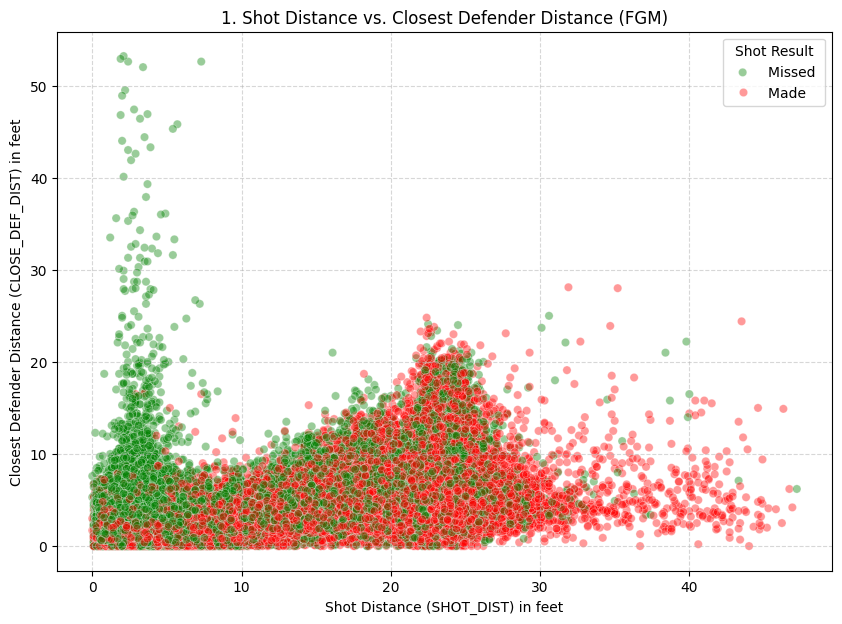

/tmp/ipykernel_89358/565889301.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=accuracy_by_type, x='PTS_TYPE', y='FGM',palette='viridis')


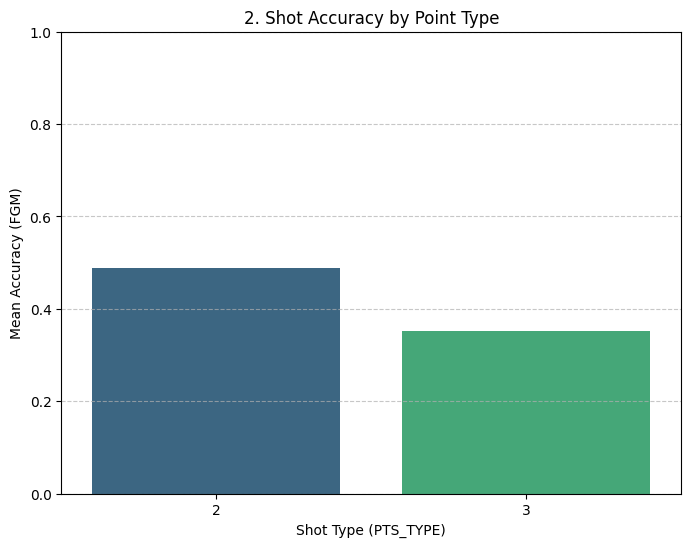

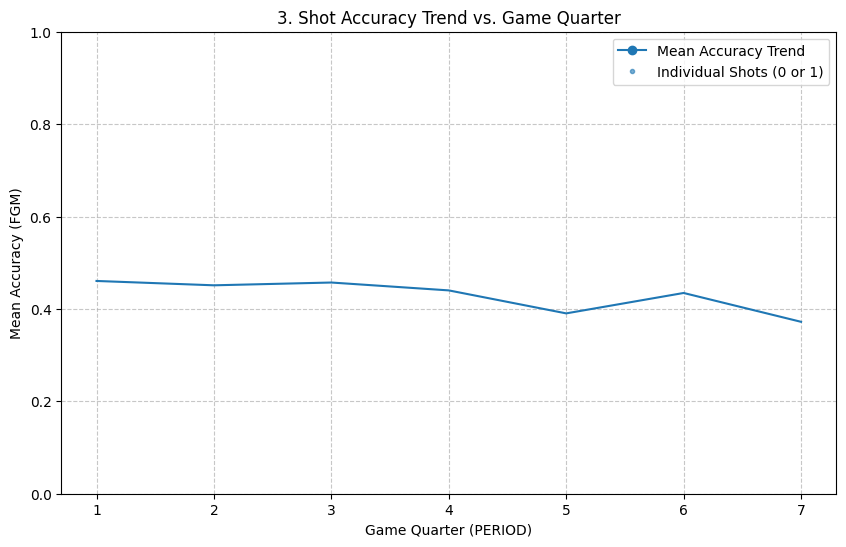

/tmp/ipykernel_89358/565889301.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=accuracy_by_location, x='LOCATION', y='FGM', palette='magma')


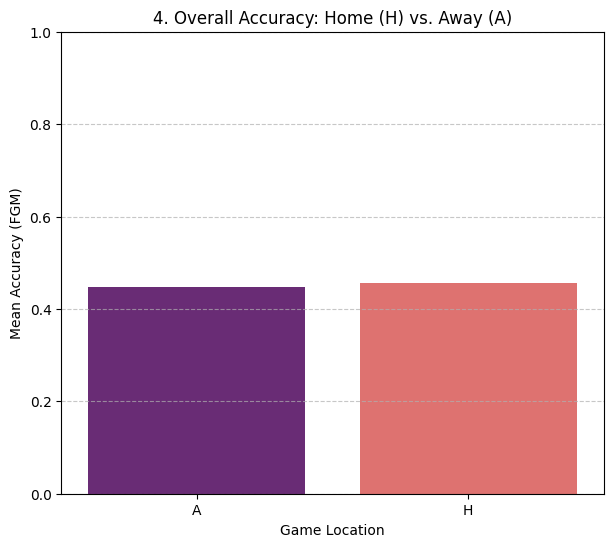

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

df_analysis = nba_shots.copy()
df_analysis['FGM'] = y 

#PLOT 1: CORRELATION DIST AND MADE SHOT 
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_analysis,x='SHOT_DIST',y='CLOSE_DEF_DIST',hue='FGM', palette={1: 'green', 0: 'red'},alpha=0.4)
plt.title('1. Shot Distance vs. Closest Defender Distance (FGM)')
plt.xlabel('Shot Distance (SHOT_DIST) in feet')
plt.ylabel('Closest Defender Distance (CLOSE_DEF_DIST) in feet')
plt.legend(title='Shot Result', labels=['Missed ', 'Made '])
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


#PLOT 2 SHOT ACCURACY BY POINT TYPE
plt.figure(figsize=(8, 6))
accuracy_by_type = df_analysis.groupby('PTS_TYPE')['FGM'].mean().reset_index()
sns.barplot(data=accuracy_by_type, x='PTS_TYPE', y='FGM',palette='viridis')
plt.title('2. Shot Accuracy by Point Type')
plt.xlabel('Shot Type (PTS_TYPE)')
plt.ylabel('Mean Accuracy (FGM)')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


#  PLOT 3 ACCURACY / GAME TIME
# Calculate mean accuracy per quarter
accuracy_by_time = df_analysis.groupby('PERIOD', observed=True)['FGM'].mean().reset_index()
fig, ax = plt.subplots(figsize=(10, 6))
# Line Plot: Shows the trend of the average accuracy (Main relation)
sns.lineplot( data=accuracy_by_time,x='PERIOD', y='FGM')
ax.set_title('3. Shot Accuracy Trend vs. Game Quarter')
ax.set_xlabel('Game Quarter (PERIOD)')
ax.set_ylabel('Mean Accuracy (FGM)')
ax.set_ylim(0, 1) # Set Y-limit to show full context
ax.grid(True, linestyle='--', alpha=0.7)
#legend
trend_line = plt.Line2D([0], [0], marker='o', label='Mean Accuracy Trend', linestyle='-')
data_points = plt.Line2D([0], [0], marker='.', label='Individual Shots (0 or 1)', linestyle='', alpha=0.6)
ax.legend(handles=[trend_line, data_points], loc='upper right')
plt.show()


# PLOT 4 OVERALL ACCURACY HOME/AWAY
plt.figure(figsize=(7, 6))
accuracy_by_location = df_analysis.groupby('LOCATION')['FGM'].mean().reset_index()
sns.barplot(data=accuracy_by_location, x='LOCATION', y='FGM', palette='magma')
plt.title('4. Overall Accuracy: Home (H) vs. Away (A)')
plt.xlabel('Game Location')
plt.ylabel('Mean Accuracy (FGM)')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
    
